In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

from pybandstructure import *

from tqdm import tqdm
import graphene as gr

## Parameters

In [2]:
#################### graphene parameters #######################################
#distances in nm, energies in eV
E_SQUARED = 1.4399764 #[eV * nm] square of elementary charge 
a = 0.246 #[nm] lattice constant of graphene
hv = 0.658 # [eV * nm] \hbar V_D
#################################################################################
theta = 1.08 #twist angle [deg]
uAB = 0.#0.110 #AB interlayer coupling [eV]
uAA = 0.#110  #AA interlayer coupling [eV]
uAB_nl = 0.#-0.2*uAB  #AB non-local interlayer coupling [eV]
uAA_nl = 0.#-0.2*uAA  #AA non-local interlayer coupling [eV]
valley = 1
density = 0.02 #electron density in [nm^-2]
temperature = 0.026 #k_B T [eV]
#################### computational parameters ##################################
n_sites = 48# number of unit cells of the crystal in one direction !must be multiple of 6!
G_max = 3.001 #number of shells considered in reciprocal space
#number of bands calculated below and above Dirac point
eta = 0.010 #energy smoothing [eV]

# Model

In [3]:
model = koshino(valley = valley, 
                uAA = uAA, 
                uAB = uAB, 
                uAA_nl = uAA_nl, 
                uAB_nl = uAB_nl,
                theta = theta, 
                hv = hv, 
                a = a, 
                G_max = G_max
               )
## length of smallest reciprocal vector
g = np.linalg.norm(model['reciprocal_lattice_vectors'].get_coords((1,0)))
n_bands = 10# * len(model['reciprocal_lattice_vectors'])

# Geometry

In [4]:
######################### Point group ###########################################
#point_group = Point_Group.dihedral_group(
#    n = 3,
#    theta0 = np.arctan2(model['reciprocal_lattice_vectors'].basis_vectors[1,0], 
#                        model['reciprocal_lattice_vectors'].basis_vectors[0,0]))
point_group = Point_Group.trivial_group(space_dimension=2)
#################################################################################
lattice_geometry = Crystal_Geometry(reciprocal_lattice_basis = model['reciprocal_lattice_vectors'].basis_vectors, 
                                    point_group = point_group)
######
Mxy = int(n_sites/2)
Kxy = int(n_sites/3)
special_points = {'$\Gamma$': (0, 0), '$M$': (Mxy, 0), '$M^\prime$': (0, Mxy), '$K$': (Kxy, Kxy)}

# Reciprocal space sampling

In [5]:
##################### k-sample ##################################################
########## Default u.c. ##########################
k_sample = Unit_Cell_Sample.default_unit_cell(basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
                                              denominator=n_sites,
                                              special_points = special_points)
########## Reduced sample ########################
#k_sample = Unit_Cell_Sample.irreducible_wigner_seitz_cell(
#    basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
#    denominator=n_sites, 
#    point_group = point_group, 
#    special_points = special_points)
##### Precompiled sample #########################
#k_sample = Unit_Cell_Sample.irreducible_sample(name = '2D_Hexagonal_D3_Axes',
#                                              basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
#                                              denominator=n_sites)
#########################################################
####################### q-sample ########################
#q_sample = Unit_Cell_Sample.default_unit_cell(basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
#                                              denominator=n_sites,
#                                              special_points = special_points)
#q_sample = Unit_Cell_Sample.wigner_seitz_cell(basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
#                                              denominator=n_sites, special_points=special_points)
q_sample = Unit_Cell_Sample.irreducible_sample(name = '2D_Hexagonal_D3_Axes',
                                              basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
                                              denominator=n_sites)

#########################################################
####################### G-sample ########################
G_sample = Sample.lattice_sample(basis_vectors=model['reciprocal_lattice_vectors'].basis_vectors, 
                                 cut_off=g * 0.0001)

# Plot samplings

..\pybandstructure\sample\sample.py:551: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
..\pybandstructure\sample\sample.py:551: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


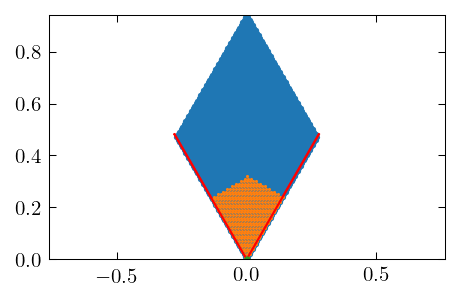

In [6]:
k_sample.plot(ms = 2.5)
q_sample.plot(ms = 1.5)
G_sample.plot(ms = 3)

In [7]:
density_operator = [
    build_density_operator(matrix = np.eye(4), G = G,reciprocal_lattice_vectors = model['reciprocal_lattice_vectors'], difference_vectors = None)
for G in G_sample]

In [8]:
band_structure = Band_Structure.from_hamiltonian(k_sample = k_sample, 
                                                 q_sample = q_sample,
                                                 G_sample = G_sample,
                                                 hamiltonian = model['hamiltonian'],
                                                 momentum_operator = model['momentum_operator'],
                                                 density_operator = density_operator,
                                                 degeneracy = 4,
                                                 zero_filling = n_bands,
                                                 density = density,
                                                 temperature = temperature)
tblg = Crystal(band_structure=band_structure, geometry=lattice_geometry, eta = eta)

In [9]:
tblg.band_structure.compute_bands(eigvals = (4 * len(model['reciprocal_lattice_vectors']) // 2 - n_bands,
                                        4 * len(model['reciprocal_lattice_vectors']) // 2 + n_bands - 1))

100%|██████████████████████████████████████████████████████████████████████████████| 2304/2304 [02:46<00:00, 13.83it/s]


In [10]:
tblg.band_structure.compute_momentum_matrix()

100%|██████████████████████████████████████████████████████████████████████████████| 2304/2304 [02:48<00:00, 13.68it/s]


In [11]:
tblg.band_structure.compute_density_matrix()

100%|██████████████████████████████████████████████████████████████████████████████| 2304/2304 [17:29<00:00,  2.20it/s]


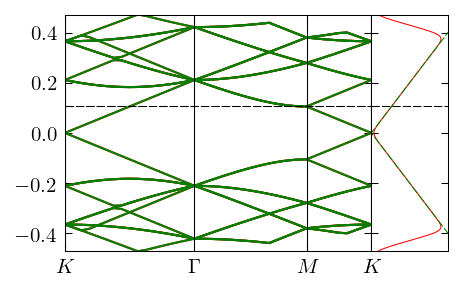

In [12]:
e_lims = -np.amax(tblg.band_structure.energies),np.amax(tblg.band_structure.energies) #energy limits for the figure
e_vals = np.linspace(*e_lims,num=200)
dosvals = tblg.dos(e_vals, shape = 'fermi')
plt.figure()
plt.axes([0.2,0.2,0.6,0.75])
_ = tblg.band_structure.plot([r'$K$', r'$\Gamma$', r'$M^\prime$', r'$K$'], c='r',emin = e_lims[0], emax=e_lims[1])
_ = tblg.band_structure.plot([r'$K$', r'$\Gamma$', r'$M$', r'$K$'],c='g',emin = e_lims[0], emax=e_lims[1])
plt.ylim(e_lims[0],e_lims[-1])
#plt.yticks(np.arange(-0.01,0.03,0.005))
ax = plt.axes([0.8,0.2,0.15,0.75])
ax.yaxis.set_label_position("right")
ax.set_xticks([])
ax.set_yticklabels([])
plt.ylim(e_lims[0],e_lims[-1])
plt.xlim(0,1.1*np.amax(dosvals))
plt.plot(dosvals ,e_vals, c='r',lw=0.5)
plt.plot(abs(e_vals)*4/(np.pi * hv**2),e_vals,'--', c='g', lw=0.5)
plt.plot([0,1.1*np.amax(dosvals)],[tblg.band_structure.chemical_potential,tblg.band_structure.chemical_potential],'--',c='k', lw=0.5)

In [13]:
chi = np.zeros([len(q_sample)], dtype = float)
chi_gr = np.zeros([len(q_sample)], dtype = float)
for i in tqdm(range(len(q_sample))):
    chi[i] =np.real(tblg.static_polarization(q_index = i, G_index = 0, G1_index = 0, use_bands = slice(None,None,None)))
    chi_gr[i] = 2. * np.real(gr.chi(omega = 0, q = np.linalg.norm(q_sample.get_coords(i)), Ef= tblg.band_structure.chemical_potential))

  0%|                                                                                          | 0/409 [00:00<?, ?it/s]..\pybandstructure\crystal\analysis\polarization_functions.py:7: RuntimeWarning: invalid value encountered in true_divide
  prefactor = occupation_diff / energy_diff
C:\Users\Windows\Dropbox\ICFO\python_projects\bandstructure-calculation\notebooks\graphene.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  Dplus  = (omega/hv_F + 2.*k_F)/q
C:\Users\Windows\Dropbox\ICFO\python_projects\bandstructure-calculation\notebooks\graphene.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  Dminus = (omega/hv_F - 2.*k_F)/q
C:\Users\Windows\Dropbox\ICFO\python_projects\bandstructure-calculation\notebooks\graphene.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  it1 = 8.*k_F/(hv_F*q*q)
C:\Users\Windows\Dropbox\ICFO\python_projects\bandstructure-calculation\notebooks\graphene.py:52: RuntimeWarning: invalid value encountered in

(-0.13318810079878096,
 0.13897888779003234,
 -1.3877787807814457e-17,
 0.32095799310899975)

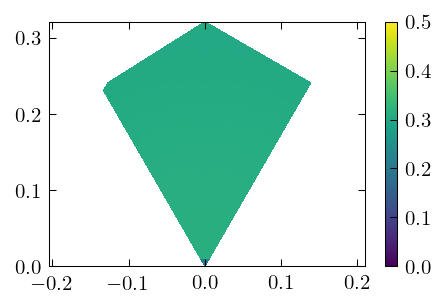

C:\Users\Windows\anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


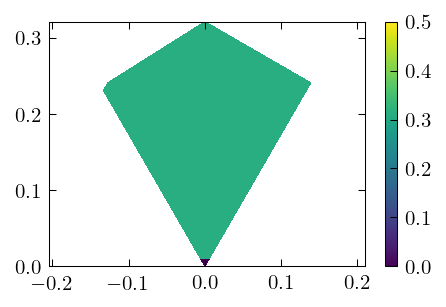

In [14]:
plt.figure()
plt.tripcolor(
q_sample.coords[:,0],
q_sample.coords[:,1],
-chi,
vmin=0,
vmax = .5
)
plt.colorbar()
plt.axis('equal')

plt.figure()
plt.tripcolor(
q_sample.coords[:,0],
q_sample.coords[:,1],
-chi_gr,
vmin=0,
vmax = .5
)
plt.colorbar()
plt.axis('equal')

In [15]:
contour = q_sample.contour([r'$K$', r'$\Gamma$', r'$M$', r'$K$'])

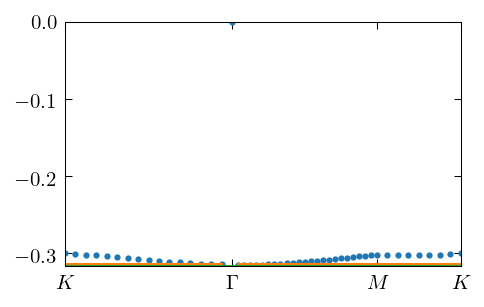

In [16]:
plt.plot(contour['x'], chi[contour['indices']],'o')
plt.plot(contour['x'], chi_gr[contour['indices']])
plt.xticks(contour['x'][contour['vertices']], [r'$K$', r'$\Gamma$', r'$M$', r'$K$'])
tblg.eta=tblg.band_structure.temperature
plt.plot(contour['x'], -np.ones_like(contour['x'])*tblg.dos(tblg.band_structure.chemical_potential,shape = 'fermi'))


In [17]:
omega_vals = np.linspace(0,.3,num=200)
chi2D = np.zeros([len(contour['indices']),len(omega_vals)], dtype = float)
for i in tqdm(range(len(contour['indices']))):
        chi2D[i,:] =np.imag(tblg.polarization(omega = omega_vals +0.01j, q_index = contour['indices'][i], G_index = 0, G1_index = 0))

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [50:47<00:00, 62.19s/it]


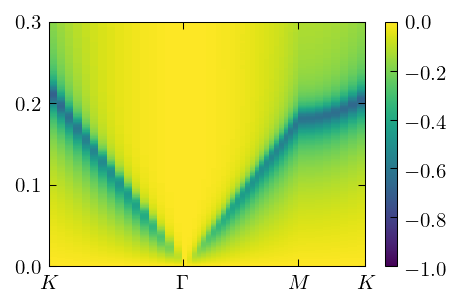

In [26]:
XX, YY = np.meshgrid(contour['x'], omega_vals)
plt.pcolormesh(XX,YY,chi2D.T,shading = 'nearest',vmin = -1,vmax = 0)
plt.xticks(contour['x'][contour['vertices']], [r'$K$', r'$\Gamma$', r'$M$', r'$K$'])
plt.colorbar()

100%|████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 2130.50it/s]


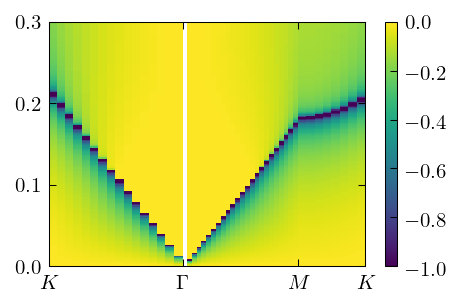

In [25]:
omega_vals = np.linspace(0,.3,num=200)
chi2D_gr = np.zeros([len(contour['indices']),len(omega_vals)], dtype = float)
for i in tqdm(range(len(contour['indices']))):
        chi2D_gr[i,:] =2. * np.imag(gr.chi(omega = omega_vals, q = np.linalg.norm(q_sample.get_coords(contour['indices'][i])), Ef= tblg.band_structure.chemical_potential))
plt.pcolormesh(XX,YY,chi2D_gr.T,shading = 'nearest',vmin = -1,vmax = 0)
plt.xticks(contour['x'][contour['vertices']], [r'$K$', r'$\Gamma$', r'$M$', r'$K$'])
plt.colorbar()

..\pybandstructure\sample\sample.py:551: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


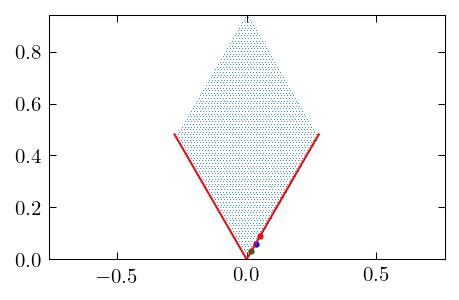

In [19]:
if True:
    k_index = 6
    q_index = 3
    k = k_sample.get_coords(k_index)
    q = q_sample.get_coords(q_index)
    kpq  = k_sample.get_coords(band_structure._k_plus_q_ind[q_index, k_index])
    plt.plot([k[0]],[k[1]],'bo')
    plt.plot([q[0]],[q[1]],'go')
    plt.plot([kpq[0]],[kpq[1]],'ro')
    k_sample.plot(ms = 0.5)

In [28]:
k_sample.save(file_format='hdf5', file_name='sample.hdf', sample_name= 'samplo')